In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
!wget -q https://downloads.apache.org/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz

In [ ]:
!tar xf spark-3.2.0-bin-hadoop3.2.tgz

In [ ]:
!pip install -q findspark

In [ ]:
import os

In [ ]:
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [ ]:
os.environ["SPARK_HOME"] = "/content/spark-3.2.0-bin-hadoop3.2"

In [ ]:
import findspark

In [ ]:
findspark.init()

In [ ]:
!pip install pyspark

     |████████████████████████████████| 281.3 MB 43 kB/s 
     |████████████████████████████████| 198 kB 44.5 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=02f80989716d6c3396e76ec311d5a9c63ac8135bae4500a8ae19e81ee61d0b3b
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


In [ ]:
from google.colab import drive
drive.mount ('/content/drive/')

Mounted at /content/drive/


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, when, count, col
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [ ]:
dataset = '/content/drive/MyDrive/Colab Notebooks/Vehicle Loan Repayment Dataset/Default_Fin.csv'

In [ ]:
spark = SparkSession.builder.appName('LoanDefault').getOrCreate()

In [ ]:
loan = spark.read.csv(dataset, header=True, inferSchema=True)

In [ ]:
loan.show()

+-----+--------+------------+-------------+----------+
|Index|Employed|Bank Balance|Annual Salary|Defaulted?|
+-----+--------+------------+-------------+----------+
|    1|       1|     8754.36|    532339.56|         0|
|    2|       0|     9806.16|    145273.56|         0|
|    3|       1|     12882.6|    381205.68|         0|
|    4|       1|      6351.0|    428453.88|         0|
|    5|       1|     9427.92|     461562.0|         0|
|    6|       0|    11035.08|     89898.72|         0|
|    7|       1|     9906.12|    298862.76|         0|
|    8|       0|     9704.04|     211205.4|         0|
|    9|       1|    13932.72|    449622.36|         0|
|   10|       1|         0.0|    351303.24|         0|
|   11|       0|         0.0|    262452.84|         0|
|   12|       0|    14646.96|    159222.72|         0|
|   13|       1|      2844.6|     339020.4|         0|
|   14|       1|     7280.88|    539934.72|         0|
|   15|       1|    13355.64|    285722.04|         0|
|   16|   

In [ ]:
loan = loan.withColumnRenamed('Defaulted?', 'Defaulted')
loan.show()

+-----+--------+------------+-------------+---------+
|Index|Employed|Bank Balance|Annual Salary|Defaulted|
+-----+--------+------------+-------------+---------+
|    1|       1|     8754.36|    532339.56|        0|
|    2|       0|     9806.16|    145273.56|        0|
|    3|       1|     12882.6|    381205.68|        0|
|    4|       1|      6351.0|    428453.88|        0|
|    5|       1|     9427.92|     461562.0|        0|
|    6|       0|    11035.08|     89898.72|        0|
|    7|       1|     9906.12|    298862.76|        0|
|    8|       0|     9704.04|     211205.4|        0|
|    9|       1|    13932.72|    449622.36|        0|
|   10|       1|         0.0|    351303.24|        0|
|   11|       0|         0.0|    262452.84|        0|
|   12|       0|    14646.96|    159222.72|        0|
|   13|       1|      2844.6|     339020.4|        0|
|   14|       1|     7280.88|    539934.72|        0|
|   15|       1|    13355.64|    285722.04|        0|
|   16|       1|     3434.76

In [ ]:
#Finding missing values

loan.select([count(when(isnan(i) | col(i).isNull(), i).alias(i)) for i in loan.columns]).show()

+--------------------------------------------------------------------------+--------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------+
|count(CASE WHEN (isnan(Index) OR (Index IS NULL)) THEN Index END AS Index)|count(CASE WHEN (isnan(Employed) OR (Employed IS NULL)) THEN Employed END AS Employed)|count(CASE WHEN (isnan(Bank Balance) OR (Bank Balance IS NULL)) THEN Bank Balance END AS `Bank Balance`)|count(CASE WHEN (isnan(Annual Salary) OR (Annual Salary IS NULL)) THEN Annual Salary END AS `Annual Salary`)|count(CASE WHEN (isnan(Defaulted) OR (Defaulted IS NULL)) THEN Defaulted END AS Defaulted)|
+-------------------------------------------------------------

In [ ]:
#Taking a sample of the pyspark dataframe and converting it to a pandas dataframe to draw a heatmap with seaborn.

loan_sample = loan.select(['Employed', 'Bank Balance', 'Annual Salary', 'Defaulted']).sample(False, 0.5, 42)
loan_pandas = loan_sample.toPandas()
loan_pandas

,Employed,Bank Balance,Annual Salary,Defaulted
0,1,6351.00,428453.88,0
1,0,9704.04,211205.40,0
2,0,0.00,262452.84,0
3,1,2844.60,339020.40,0
4,1,0.00,603183.72,0
...,...,...,...,...
5072,1,13339.80,545888.16,0
5073,1,11266.08,679601.40,0
5074,0,2068.92,179471.28,0
5075,1,18828.12,440029.32,0


In [ ]:
correlation = loan_pandas.corr()

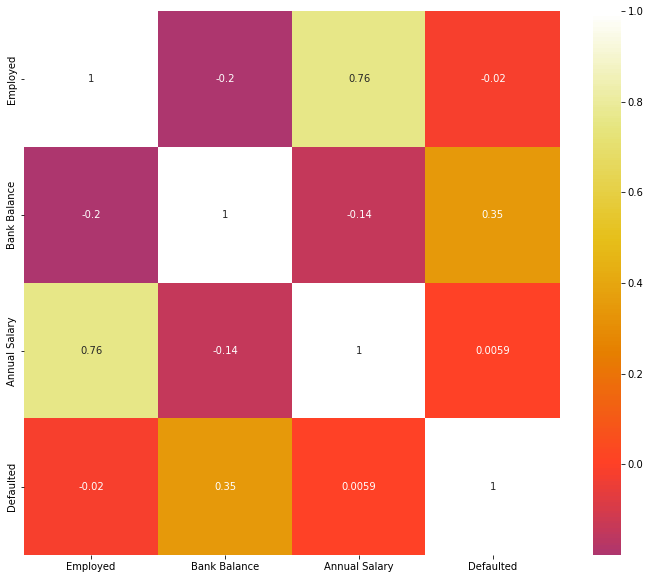

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlation, xticklabels=correlation.columns, yticklabels=correlation.columns, annot=True, cmap='CMRmap', center=0)
plt.show()

In [ ]:
# Back to the pyspark dataframe. The features 'Employed' and 'Annual Salary' have a correlation of 0.76. Therefore, 'Employed' can be dropped.

loan = loan.drop('Employed', 'Index')
loan.show()

+------------+-------------+---------+
|Bank Balance|Annual Salary|Defaulted|
+------------+-------------+---------+
|     8754.36|    532339.56|        0|
|     9806.16|    145273.56|        0|
|     12882.6|    381205.68|        0|
|      6351.0|    428453.88|        0|
|     9427.92|     461562.0|        0|
|    11035.08|     89898.72|        0|
|     9906.12|    298862.76|        0|
|     9704.04|     211205.4|        0|
|    13932.72|    449622.36|        0|
|         0.0|    351303.24|        0|
|         0.0|    262452.84|        0|
|    14646.96|    159222.72|        0|
|      2844.6|     339020.4|        0|
|     7280.88|    539934.72|        0|
|    13355.64|    285722.04|        0|
|     3434.76|    540508.92|        0|
|         0.0|    603183.72|        0|
|     6330.48|    211638.48|        0|
|     5831.28|    738793.32|        0|
|    13140.84|    317575.56|        0|
+------------+-------------+---------+
only showing top 20 rows



In [ ]:
vectors_assembled = VectorAssembler(inputCols=['Bank Balance', 'Annual Salary'], outputCol='features')

In [ ]:
transformed_loan = vectors_assembled.transform(loan)

In [ ]:
final_loan = transformed_loan.select('features', 'Defaulted')

In [ ]:
train, test = final_loan.randomSplit([0.8, 0.2], seed=42)

In [ ]:
dt = DecisionTreeClassifier(labelCol='Defaulted', featuresCol='features')
model_dt = dt.fit(train)

In [ ]:
pred_dectree = model_dt.transform(test)

In [ ]:
rf = RandomForestClassifier(labelCol='Defaulted', featuresCol='features')
model_rf = rf.fit(train)

In [ ]:
pred_rf = model_rf.transform(test)

In [ ]:
score = MulticlassClassificationEvaluator(labelCol='Defaulted', predictionCol='prediction', metricName='accuracy')

In [ ]:
dt_score = score.evaluate(pred_dectree)
dt_score

0.9692868297761582

In [ ]:
rf_score = score.evaluate(pred_rf)
rf_score

0.967725143154607